In [43]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats as stats

Scenario: EcomX Retailers is a mid-sized online retail company specializing in electronics, clothing, and home goods. The company has been growing steadily over the past few years and wants to optimize its marketing and customer retention strategies. One key aspect of this strategy is to understand the Customer Lifetime Value (CLV) of its customers. By predicting the CLV, EcomX aims to identify high-value customers and tailor personalized marketing efforts to retain them, while also identifying low-value customers to manage resources effectively.

Objective: The objective of this assignment is to build and evaluate a machine learning model to predict the Customer Lifetime Value (CLV) of EcomX’s customers. You will need to identify and apply various data cleaning and preparation techniques, as well as select an appropriate model and evaluation criteria.

In [44]:
customer = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

Data Cleaning (Missing Values)

In [45]:
customer.head()

,customer_id,join_date,last_purchase_date,age,gender,location
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury
1,2,2021-09-08,2023-10-25,NaN,Male,Hillville
2,3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad
4,5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort


In [46]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  int64  
 1   join_date           10000 non-null  object 
 2   last_purchase_date  10000 non-null  object 
 3   age                 8991 non-null   float64
 4   gender              9467 non-null   object 
 5   location            10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB


In [47]:
customer.describe()

,customer_id,age
count,10000.00000,8991.000000
mean,5000.50000,43.467467
std,2886.89568,15.094380
min,1.00000,18.000000
25%,2500.75000,30.000000
50%,5000.50000,44.000000
75%,7500.25000,57.000000
max,10000.00000,69.000000


In [48]:
#fill out missing value to customer's age column
customer['age']= customer['age'].fillna(customer['age'].mean())

In [49]:
customer['age']= customer['age'].astype(int)

In [50]:
customer.head()

,customer_id,join_date,last_purchase_date,age,gender,location
0,1,2023-11-20,2024-03-17,56,Female,North Shannonbury
1,2,2021-09-08,2023-10-25,43,Male,Hillville
2,3,2021-06-01,2022-11-27,43,NaN,North Latoyatown
3,4,2022-01-01,2022-09-01,29,Male,Grossstad
4,5,2022-01-24,2023-06-02,43,Male,East Matthewfort


In [51]:
#fill out missing data under gender column
def gender_type(x):
    if x == 'Female':
        return 'Female'
    elif x == 'Male':
        return 'Male'
    else:
        return 'Other'


In [52]:
customer['gender'] = customer['gender'].apply(gender_type)

In [53]:
#check if the missing data is gone
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         10000 non-null  int64 
 1   join_date           10000 non-null  object
 2   last_purchase_date  10000 non-null  object
 3   age                 10000 non-null  int32 
 4   gender              10000 non-null  object
 5   location            10000 non-null  object
dtypes: int32(1), int64(1), object(4)
memory usage: 429.8+ KB


In [54]:
engagement.head()

,customer_id,number_of_site_visits,number_of_emails_opened,number_of_clicks
0,1,10,15,1
1,2,285,49,51
2,3,192,73,25
3,4,110,30,17
4,5,161,2,7


In [55]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_id              10000 non-null  int64
 1   number_of_site_visits    10000 non-null  int64
 2   number_of_emails_opened  10000 non-null  int64
 3   number_of_clicks         10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB


In [56]:
engagement.describe()

,customer_id,number_of_site_visits,number_of_emails_opened,number_of_clicks
count,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,100.111900,39.862100,19.725300
std,2886.89568,118.625052,46.511719,22.975083
min,1.00000,1.000000,1.000000,1.000000
25%,2500.75000,15.000000,6.000000,3.000000
50%,5000.50000,53.000000,22.000000,11.000000
75%,7500.25000,141.000000,57.000000,28.000000
max,10000.00000,711.000000,303.000000,142.000000


In [57]:
engagement[engagement['number_of_site_visits'] == 711]

,customer_id,number_of_site_visits,number_of_emails_opened,number_of_clicks
4052,4053,711,17,1


In [58]:
marketing.head()

,campaign_id,customer_id,response,promotion_type,campaign_date
0,1,1,No,Buy One Get One,2024-02-29
1,2,1,No,Discount,2024-01-24
2,3,1,No,Free Shipping,2024-03-05
3,4,1,Yes,Buy One Get One,2024-01-10
4,5,2,Yes,Free Shipping,2022-07-08


In [59]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   campaign_id     25200 non-null  int64 
 1   customer_id     25200 non-null  int64 
 2   response        25200 non-null  object
 3   promotion_type  25200 non-null  object
 4   campaign_date   25200 non-null  object
dtypes: int64(2), object(3)
memory usage: 984.5+ KB


In [60]:
transactions.head()

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics


In [61]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129545 entries, 0 to 129544
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      129545 non-null  int64  
 1   customer_id         129545 non-null  int64  
 2   transaction_date    129545 non-null  object 
 3   transaction_amount  129545 non-null  float64
 4   product_category    129545 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.9+ MB


In [62]:
customer['join_date'] = pd.to_datetime(customer['join_date'])
customer['last_purchase_date'] = pd.to_datetime(customer['last_purchase_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])

Join Tables

In [63]:
# split at customer level with # of marketing campaigns customer responded YES and No
# step 1: marketing data at a customer level

marketing_agg_yes = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()
marketing_agg_no = marketing[marketing['response']=='No'].groupby('customer_id')['campaign_id'].count().to_frame()

In [64]:
# step 2: aggregate transaction data at a customer level
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

In [65]:
# step 3: set customers and engagement index as customer_id
customer.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)

In [66]:
# step 4: join all tables
joint_data_yes = customer.join(engagement).join(transactions_agg).join(marketing_agg_yes)
joint_data_no = customer.join(engagement).join(transactions_agg).join(marketing_agg_no)

In [67]:
# now you have a customer level data set;  you will see some NaN values under campaign_id because some customers haven't been targeted with any marketing campaigns
joint_data_yes

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,43,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,43,Other,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,43,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39,Male,New John,53,17,5,3,3503.13,1.0


In [68]:
joint_data_yes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   join_date                10000 non-null  datetime64[ns]
 1   last_purchase_date       10000 non-null  datetime64[ns]
 2   age                      10000 non-null  int32         
 3   gender                   10000 non-null  object        
 4   location                 10000 non-null  object        
 5   number_of_site_visits    10000 non-null  int64         
 6   number_of_emails_opened  10000 non-null  int64         
 7   number_of_clicks         10000 non-null  int64         
 8   transaction_id           10000 non-null  int64         
 9   transaction_amount       10000 non-null  float64       
 10  campaign_id              7665 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int32(1), int64(4), object(2)
memory usage: 1.1+ MB


In [69]:
#set missing campaign id as 0 to mark the customer who are not target for campaign
joint_data_yes['campaign_id']= joint_data_yes['campaign_id'].fillna(0)
joint_data_yes

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,43,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,43,Other,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,43,Male,East Matthewfort,161,2,7,24,15524.55,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42,Female,Johnstonborough,119,47,16,10,5498.20,0.0
9997,2022-07-09,2023-01-25,26,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39,Male,New John,53,17,5,3,3503.13,1.0


In [70]:
joint_data_no

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,Female,North Shannonbury,10,15,1,6,3509.48,3.0
2,2021-09-08,2023-10-25,43,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,43,Other,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29,Male,Grossstad,110,30,17,20,7874.68,3.0
5,2022-01-24,2023-06-02,43,Male,East Matthewfort,161,2,7,24,15524.55,4.0
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42,Female,Johnstonborough,119,47,16,10,5498.20,3.0
9997,2022-07-09,2023-01-25,26,Male,Jessicamouth,3,33,14,12,5848.30,NaN
9998,2023-09-17,2024-01-30,39,Male,New John,53,17,5,3,3503.13,NaN


Feature engineering

In [71]:
#create a new column named 'average_purchase_value'
joint_data_yes['average_purchase_value_per_transaction'] = joint_data_yes['transaction_amount']/joint_data_yes['transaction_id']
joint_data_yes

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,average_purchase_value_per_transaction
customer_id,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,Female,North Shannonbury,10,15,1,6,3509.48,1.0,584.913333
2,2021-09-08,2023-10-25,43,Male,Hillville,285,49,51,9,6081.32,2.0,675.702222
3,2021-06-01,2022-11-27,43,Other,North Latoyatown,192,73,25,6,1454.87,1.0,242.478333
4,2022-01-01,2022-09-01,29,Male,Grossstad,110,30,17,20,7874.68,1.0,393.734000
5,2022-01-24,2023-06-02,43,Male,East Matthewfort,161,2,7,24,15524.55,0.0,646.856250
...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42,Female,Johnstonborough,119,47,16,10,5498.20,0.0,549.820000
9997,2022-07-09,2023-01-25,26,Male,Jessicamouth,3,33,14,12,5848.30,1.0,487.358333
9998,2023-09-17,2024-01-30,39,Male,New John,53,17,5,3,3503.13,1.0,1167.710000


In [72]:
#Customer Lifetime Value = (Customer Value * Average Customer Lifespan)
#create column 'customer_lifespan' in years
joint_data_yes['customer_lifetime'] = joint_data_yes['last_purchase_date'] - joint_data_yes['join_date']
joint_data_yes['customer_lifetime'] = joint_data_yes['customer_lifetime']/pd.Timedelta('365 days')
joint_data_yes

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,average_purchase_value_per_transaction,customer_lifetime
customer_id,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,Female,North Shannonbury,10,15,1,6,3509.48,1.0,584.913333,0.323288
2,2021-09-08,2023-10-25,43,Male,Hillville,285,49,51,9,6081.32,2.0,675.702222,2.128767
3,2021-06-01,2022-11-27,43,Other,North Latoyatown,192,73,25,6,1454.87,1.0,242.478333,1.490411
4,2022-01-01,2022-09-01,29,Male,Grossstad,110,30,17,20,7874.68,1.0,393.734000,0.665753
5,2022-01-24,2023-06-02,43,Male,East Matthewfort,161,2,7,24,15524.55,0.0,646.856250,1.353425
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42,Female,Johnstonborough,119,47,16,10,5498.20,0.0,549.820000,0.657534
9997,2022-07-09,2023-01-25,26,Male,Jessicamouth,3,33,14,12,5848.30,1.0,487.358333,0.547945
9998,2023-09-17,2024-01-30,39,Male,New John,53,17,5,3,3503.13,1.0,1167.710000,0.369863


In [73]:
from sklearn.preprocessing import StandardScaler,LabelEncoder

#label encode categorical data
le = LabelEncoder()
joint_data_yes['gender']=le.fit_transform(joint_data_yes['gender'])
joint_data_yes['location']=le.fit_transform(joint_data_yes['location'])
joint_data_yes

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,average_purchase_value_per_transaction,customer_lifetime
customer_id,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,0,4747,10,15,1,6,3509.48,1.0,584.913333,0.323288
2,2021-09-08,2023-10-25,43,1,2074,285,49,51,9,6081.32,2.0,675.702222,2.128767
3,2021-06-01,2022-11-27,43,2,4613,192,73,25,6,1454.87,1.0,242.478333,1.490411
4,2022-01-01,2022-09-01,29,1,1916,110,30,17,20,7874.68,1.0,393.734000,0.665753
5,2022-01-24,2023-06-02,43,1,1433,161,2,7,24,15524.55,0.0,646.856250,1.353425
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42,0,2384,119,47,16,10,5498.20,0.0,549.820000,0.657534
9997,2022-07-09,2023-01-25,26,1,2315,3,33,14,12,5848.30,1.0,487.358333,0.547945
9998,2023-09-17,2024-01-30,39,1,4017,53,17,5,3,3503.13,1.0,1167.710000,0.369863


In [74]:
joint_data_yes.describe()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,average_purchase_value_per_transaction,customer_lifetime
count,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2022-03-19 09:28:13.439999744,2023-04-25 18:26:12.480000,43.420300,0.583500,3883.754200,100.111900,39.862100,19.725300,12.954500,7737.562981,1.257800,599.842451,1.102393
min,2020-01-01 00:00:00,2020-01-26 00:00:00,18.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,23.810000,0.000000,23.810000,0.000000
25%,2021-02-15 00:00:00,2022-09-19 00:00:00,32.000000,0.000000,2007.750000,15.000000,6.000000,3.000000,7.000000,3839.915000,1.000000,488.343409,0.295890
50%,2022-03-19 00:00:00,2023-08-04 00:00:00,43.000000,1.000000,3886.500000,53.000000,22.000000,11.000000,13.000000,7498.890000,1.000000,587.587333,0.821918
75%,2023-04-28 00:00:00,2024-02-11 00:00:00,55.000000,1.000000,5811.250000,141.000000,57.000000,28.000000,19.000000,11275.797500,2.000000,692.701750,1.693151
max,2024-05-31 00:00:00,2024-05-31 00:00:00,69.000000,2.000000,7694.000000,711.000000,303.000000,142.000000,25.000000,24298.220000,4.000000,1997.080000,4.336986
std,NaN,NaN,14.313236,0.591323,2214.035304,118.625052,46.511719,22.975083,7.191203,4628.799469,0.971511,197.350557,0.974601


In [75]:
#creating lifetime value per year per customer
joint_data_yes['customer_lifetime_value'] = joint_data_yes['transaction_amount']/joint_data_yes['customer_lifetime']

In [76]:
joint_data_yes

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,average_purchase_value_per_transaction,customer_lifetime,customer_lifetime_value
customer_id,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,0,4747,10,15,1,6,3509.48,1.0,584.913333,0.323288,10855.594915
2,2021-09-08,2023-10-25,43,1,2074,285,49,51,9,6081.32,2.0,675.702222,2.128767,2856.733333
3,2021-06-01,2022-11-27,43,2,4613,192,73,25,6,1454.87,1.0,242.478333,1.490411,976.153585
4,2022-01-01,2022-09-01,29,1,1916,110,30,17,20,7874.68,1.0,393.734000,0.665753,11828.223045
5,2022-01-24,2023-06-02,43,1,1433,161,2,7,24,15524.55,0.0,646.856250,1.353425,11470.568320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42,0,2384,119,47,16,10,5498.20,0.0,549.820000,0.657534,8361.845833
9997,2022-07-09,2023-01-25,26,1,2315,3,33,14,12,5848.30,1.0,487.358333,0.547945,10673.147500
9998,2023-09-17,2024-01-30,39,1,4017,53,17,5,3,3503.13,1.0,1167.710000,0.369863,9471.425556


In [83]:
def level_of_site_visits(x):
    if x <= 150:
        return 'low'
    elif x>150 and x <= 400:
        return 'medium'
    else:
        return 'high'

In [84]:
joint_data_yes['level_of_site_visits'] = joint_data_yes['number_of_clicks'].apply(level_of_site_visits)
joint_data_yes

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,average_purchase_value_per_transaction,customer_lifetime,customer_lifetime_value,level_of_site_visits
customer_id,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,0,4747,10,15,1,6,3509.48,1.0,584.913333,0.323288,10855.594915,low
2,2021-09-08,2023-10-25,43,1,2074,285,49,51,9,6081.32,2.0,675.702222,2.128767,2856.733333,low
3,2021-06-01,2022-11-27,43,2,4613,192,73,25,6,1454.87,1.0,242.478333,1.490411,976.153585,low
4,2022-01-01,2022-09-01,29,1,1916,110,30,17,20,7874.68,1.0,393.734000,0.665753,11828.223045,low
5,2022-01-24,2023-06-02,43,1,1433,161,2,7,24,15524.55,0.0,646.856250,1.353425,11470.568320,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42,0,2384,119,47,16,10,5498.20,0.0,549.820000,0.657534,8361.845833,low
9997,2022-07-09,2023-01-25,26,1,2315,3,33,14,12,5848.30,1.0,487.358333,0.547945,10673.147500,low
9998,2023-09-17,2024-01-30,39,1,4017,53,17,5,3,3503.13,1.0,1167.710000,0.369863,9471.425556,low


In [85]:
import seaborn as sns

import matplotlib.pyplot as plt

<Axes: xlabel='level_of_site_visits', ylabel='customer_lifetime_value'>

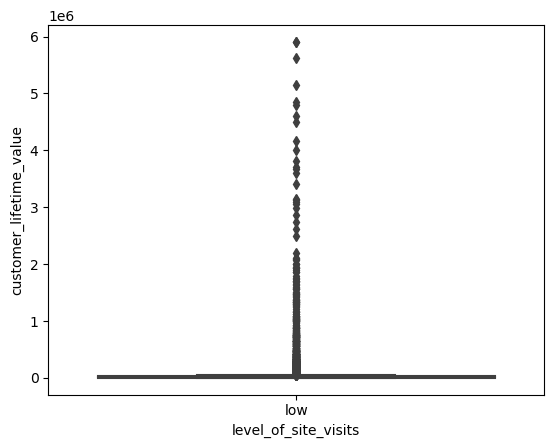

In [87]:
#evaluate transaction amount vs # of transactions 
sns.boxplot(x='level_of_site_visits', y='customer_lifetime_value', data=joint_data_yes, palette='tab10')

Modeling

In [93]:
train, test = train_test_split(joint_data_yes, test_size=0.3,random_state=1234)

In [94]:
features = ['number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks', 'transaction_id', 'transaction_amount',
       'campaign_id', 'customer_lifetime']

target = 'customer_lifetime_value'

In [95]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, PrecisionRecallDisplay, precision_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [96]:
#cross validation - divide dataset to 5 sections, train 4 sections and test 1 section, repeat the process 5 times
#quickly create 5 models and pick the best one
scores = cross_val_score(RandomeForest(), train[features], train[target], cv=5, scoring='accuracy')

c:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y contains infinity or a value too large for dtype('float64').

In [88]:
joint_data_yes

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,average_purchase_value_per_transaction,customer_lifetime,customer_lifetime_value,level_of_site_visits
customer_id,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,0,4747,10,15,1,6,3509.48,1.0,584.913333,0.323288,10855.594915,low
2,2021-09-08,2023-10-25,43,1,2074,285,49,51,9,6081.32,2.0,675.702222,2.128767,2856.733333,low
3,2021-06-01,2022-11-27,43,2,4613,192,73,25,6,1454.87,1.0,242.478333,1.490411,976.153585,low
4,2022-01-01,2022-09-01,29,1,1916,110,30,17,20,7874.68,1.0,393.734000,0.665753,11828.223045,low
5,2022-01-24,2023-06-02,43,1,1433,161,2,7,24,15524.55,0.0,646.856250,1.353425,11470.568320,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42,0,2384,119,47,16,10,5498.20,0.0,549.820000,0.657534,8361.845833,low
9997,2022-07-09,2023-01-25,26,1,2315,3,33,14,12,5848.30,1.0,487.358333,0.547945,10673.147500,low
9998,2023-09-17,2024-01-30,39,1,4017,53,17,5,3,3503.13,1.0,1167.710000,0.369863,9471.425556,low
